<center><h1>Pranav Pandy Mohanapandian_Project</h1></center>

<b>1. Transfer Learning for Image Classification.

 In this problem, we are trying to build a classifier that distinguishes images of
nine types of waste. <b>

In [4]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2

In [5]:
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))
print("GPU Name:", tf.test.gpu_device_name())

Num GPUs Available: 1
GPU Name: /device:GPU:0


<b> Data Exploration and Pre-processing.

Images are numbered in each folder. Select the first 80% of the images in
each folder as your training set and the rest as the test set. You can encode
your classes using one-hot encoding.

 In case all the images do not have the same size, zero-pad or resize the images
in your dataset. This can be done using various tools, including OpenCV.<b>

In [6]:
IMAGE_SIZE = (224, 224)
DATASET_PATH = "/content/drive/MyDrive/RealWaste"
BATCH_SIZE = 5
EPOCHS = 100

X, y = [], []
labels = sorted(os.listdir(DATASET_PATH))
label_map = {label: idx for idx, label in enumerate(labels)}

for label in labels:
    folder_path = os.path.join(DATASET_PATH, label)
    files = sorted(os.listdir(folder_path))
    for img_name in files:
        img_path = os.path.join(folder_path, img_name)
        img = cv2.imread(img_path)
        if img is not None:
            img = cv2.resize(img, IMAGE_SIZE)
            X.append(img)
            y.append(label_map[label])

X, y = np.array(X), np.array(y)
y_cat = to_categorical(y, num_classes=len(labels))

In [7]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y_cat, stratify=y_cat, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, stratify=y_temp, test_size=0.5, random_state=42)

train_aug = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.15,
    brightness_range=[0.8, 1.2],
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)

In [8]:
y_train_labels = np.argmax(y_train, axis=1)
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train_labels), y=y_train_labels)
class_weight_dict = dict(enumerate(class_weights))

early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1)

<b> Transfer Learning. 


When dealing with classification of relatively small image datasets, deep networks may not perform very well because of not having enough data to train them. In such cases, one usually uses transfer learning, which uses deep learning models that are trained on very large datasets such as ImageNet
as feature extractors. The idea is that such deep networks have learned to extract meaningful features from an image using their layers, and those features can be used in learning other tasks. In order to do that, usually the last layer or the last few layers of the pre-trained network are removed, and the response of the layer before the removed layers to the images in the new dataset is used as a feature vector to train one more multiple replacement layers. In this project, you will use pre-trained models ResNet50, ResNet100, EfficientNetB0, and VGG16. For those pre-trained networks, you will only train the last fully connected layer, and will freeze all layers before them (i.e. we do not change their parameters during training) and use the outputs of the penultimate layer in the original pre-trained model as the features extracted
from each image.

 To perform empirical regularization, crop, randomly zoom, rotate, flip, contrast, and translate images in your training set for image augmentation. You can use various tools to do this, including OpenCV.

 Use ReLU activation functions in the last layer and a softmax layer, along with L2 regularization, batch normalization 3, and a dropout rate of 20% as well as ADAM optimizer. Use multinomial cross entropy loss. You can try any batch size, but a batch size of 5 seems reasonable.

 Train the networks for at least 50 epochs (preferably 100 epochs) and perform early stopping using the validation set. Use a randomly selected subset of 20% of each class as the validation set. Keep the network parameters that have the lowest validation error. Plot the training and validation errors vs. epochs.<b>

In [9]:
def train_model(base_model_fn, model_name, preprocess_fn=None, lr=1e-5):
    print(f"\n--- Training {model_name} ---")
    X_proc = preprocess_fn(X.copy()) if preprocess_fn else X.copy()

    X_train_proc, X_temp_proc, y_train_proc, y_temp_proc = train_test_split(X_proc, y_cat, stratify=y_cat, test_size=0.2, random_state=42)
    X_val_proc, X_test_proc, y_val_proc, y_test_proc = train_test_split(X_temp_proc, y_temp_proc, stratify=y_temp_proc, test_size=0.5, random_state=42)

    base_model = base_model_fn(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    base_model.trainable = False

    x = GlobalAveragePooling2D()(base_model.output)
    x = Dense(256, activation='relu', kernel_regularizer=l2(0.01))(x)
    x = BatchNormalization()(x)
    x = Dense(128, activation='relu', kernel_regularizer=l2(0.01))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)
    x = Dense(64, activation='relu', kernel_regularizer=l2(0.01))(x)
    x = BatchNormalization()(x)
    output = Dense(len(labels), activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=output)
    model.compile(optimizer=Adam(learning_rate=lr), loss='categorical_crossentropy', metrics=['accuracy'])

    history = model.fit(
        train_aug.flow(X_train_proc, y_train_proc, batch_size=BATCH_SIZE),
        validation_data=(X_val_proc, y_val_proc),
        epochs=EPOCHS,
        callbacks=[early_stop, reduce_lr],
        class_weight=class_weight_dict,
        verbose=1
    )
    return model, history

In [10]:
from tensorflow.keras.applications import VGG16, ResNet50, ResNet101, EfficientNetB0
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet_preproc
from tensorflow.keras.applications.vgg16 import preprocess_input as vgg_preproc
from tensorflow.keras.applications.efficientnet import preprocess_input as eff_preproc

In [11]:
models = {}
histories = {}

for name, model_fn, preproc, lr in [
    ("VGG16", VGG16, vgg_preproc, 1e-5),
    ("ResNet50", ResNet50, resnet_preproc, 1e-5),
    ("ResNet101", ResNet101, resnet_preproc, 1e-5),
    ("EfficientNetB0", EfficientNetB0, eff_preproc, 1e-4)
]:
    model, history = train_model(model_fn, name, preprocess_fn=preproc, lr=lr)
    models[name] = model
    histories[name] = history


--- Training VGG16 ---
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


761/761 ━━━━━━━━━━━━━━━━━━━━ 80s 93ms/step - accuracy: 0.0988 - loss: 8.8787 - val_accuracy: 0.1347 - val_loss: 9.6661 - learning_rate: 1.0000e-05
Epoch 2/100
761/761 ━━━━━━━━━━━━━━━━━━━━ 48s 64ms/step - accuracy: 0.1359 - loss: 8.6289 - val_accuracy: 0.1705 - val_loss: 9.3352 - learning_rate: 1.0000e-05
Epoch 3/100
761/761 ━━━━━━━━━━━━━━━━━━━━ 48s 63ms/step - accuracy: 0.1604 - loss: 8.4182 - val_accuracy: 0.1937 - val_loss: 9.1641 - learning_rate: 1.0000e-05
Epoch 4/100
761/761 ━━━━━━━━━━━━━━━━━━━━ 50s 65ms/step - accuracy: 0.1868 - loss: 8.3447 - val_accuracy: 0.2126 - val_loss: 8.9832 - learning_rate: 1.0000e-05
Epoch 5/100
761/761 ━━━━━━━━━━━━━━━━━━━━ 52s 68ms/step - accuracy: 0.1917 - loss: 8.2521 - val_accuracy: 0.2274 - val_loss: 8.8000 - learning_rate: 1.0000e-05
Epoch 6/100
761/761 ━━━━━━━━━━━━━━━━━━━━ 52s 68ms/step - accuracy: 0.2269 - loss: 8.1267 - val_accuracy: 0.2463 - val_loss: 8.6704 - learning_rate: 1.0000e-05
Epoch 7/100
761/761 ━━━━━━━━━━━━━━━━━━━━ 51s 67ms/step - a

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


761/761 ━━━━━━━━━━━━━━━━━━━━ 78s 84ms/step - accuracy: 0.1225 - loss: 9.8678 - val_accuracy: 0.1516 - val_loss: 10.2811 - learning_rate: 1.0000e-05
Epoch 2/100
761/761 ━━━━━━━━━━━━━━━━━━━━ 48s 63ms/step - accuracy: 0.1852 - loss: 9.5452 - val_accuracy: 0.1916 - val_loss: 9.9071 - learning_rate: 1.0000e-05
Epoch 3/100
761/761 ━━━━━━━━━━━━━━━━━━━━ 48s 63ms/step - accuracy: 0.2245 - loss: 9.3111 - val_accuracy: 0.2316 - val_loss: 9.7204 - learning_rate: 1.0000e-05
Epoch 4/100
761/761 ━━━━━━━━━━━━━━━━━━━━ 48s 63ms/step - accuracy: 0.2654 - loss: 9.1398 - val_accuracy: 0.2821 - val_loss: 9.4793 - learning_rate: 1.0000e-05
Epoch 5/100
761/761 ━━━━━━━━━━━━━━━━━━━━ 48s 63ms/step - accuracy: 0.2977 - loss: 9.0005 - val_accuracy: 0.2905 - val_loss: 9.4470 - learning_rate: 1.0000e-05
Epoch 6/100
761/761 ━━━━━━━━━━━━━━━━━━━━ 48s 63ms/step - accuracy: 0.3256 - loss: 8.8552 - val_accuracy: 0.3158 - val_loss: 9.4128 - learning_rate: 1.0000e-05
Epoch 7/100
761/761 ━━━━━━━━━━━━━━━━━━━━ 48s 63ms/step - 

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


761/761 ━━━━━━━━━━━━━━━━━━━━ 84s 85ms/step - accuracy: 0.1305 - loss: 9.7862 - val_accuracy: 0.1368 - val_loss: 10.2652 - learning_rate: 1.0000e-05
Epoch 2/100
761/761 ━━━━━━━━━━━━━━━━━━━━ 49s 64ms/step - accuracy: 0.1800 - loss: 9.5565 - val_accuracy: 0.1874 - val_loss: 10.0518 - learning_rate: 1.0000e-05
Epoch 3/100
761/761 ━━━━━━━━━━━━━━━━━━━━ 49s 64ms/step - accuracy: 0.2222 - loss: 9.3526 - val_accuracy: 0.2316 - val_loss: 9.7754 - learning_rate: 1.0000e-05
Epoch 4/100
761/761 ━━━━━━━━━━━━━━━━━━━━ 48s 63ms/step - accuracy: 0.2599 - loss: 9.1342 - val_accuracy: 0.2611 - val_loss: 9.5953 - learning_rate: 1.0000e-05
Epoch 5/100
761/761 ━━━━━━━━━━━━━━━━━━━━ 48s 64ms/step - accuracy: 0.2983 - loss: 9.0076 - val_accuracy: 0.3095 - val_loss: 9.3467 - learning_rate: 1.0000e-05
Epoch 6/100
761/761 ━━━━━━━━━━━━━━━━━━━━ 48s 63ms/step - accuracy: 0.3218 - loss: 8.8994 - val_accuracy: 0.3242 - val_loss: 9.2419 - learning_rate: 1.0000e-05
Epoch 7/100
761/761 ━━━━━━━━━━━━━━━━━━━━ 49s 64ms/step -

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


761/761 ━━━━━━━━━━━━━━━━━━━━ 98s 97ms/step - accuracy: 0.1914 - loss: 9.1460 - val_accuracy: 0.3326 - val_loss: 8.7829 - learning_rate: 1.0000e-04
Epoch 2/100
761/761 ━━━━━━━━━━━━━━━━━━━━ 46s 61ms/step - accuracy: 0.4169 - loss: 8.1877 - val_accuracy: 0.4653 - val_loss: 8.1438 - learning_rate: 1.0000e-04
Epoch 3/100
761/761 ━━━━━━━━━━━━━━━━━━━━ 45s 60ms/step - accuracy: 0.5081 - loss: 7.7680 - val_accuracy: 0.4884 - val_loss: 7.7269 - learning_rate: 1.0000e-04
Epoch 4/100
761/761 ━━━━━━━━━━━━━━━━━━━━ 46s 60ms/step - accuracy: 0.5282 - loss: 7.4458 - val_accuracy: 0.5453 - val_loss: 7.3499 - learning_rate: 1.0000e-04
Epoch 5/100
761/761 ━━━━━━━━━━━━━━━━━━━━ 46s 60ms/step - accuracy: 0.5686 - loss: 7.0926 - val_accuracy: 0.5937 - val_loss: 6.9718 - learning_rate: 1.0000e-04
Epoch 6/100
761/761 ━━━━━━━━━━━━━━━━━━━━ 46s 60ms/step - accuracy: 0.6111 - loss: 6.7527 - val_accuracy: 0.6084 - val_loss: 6.6383 - learning_rate: 1.0000e-04
Epoch 7/100
761/761 ━━━━━━━━━━━━━━━━━━━━ 45s 59ms/step - a

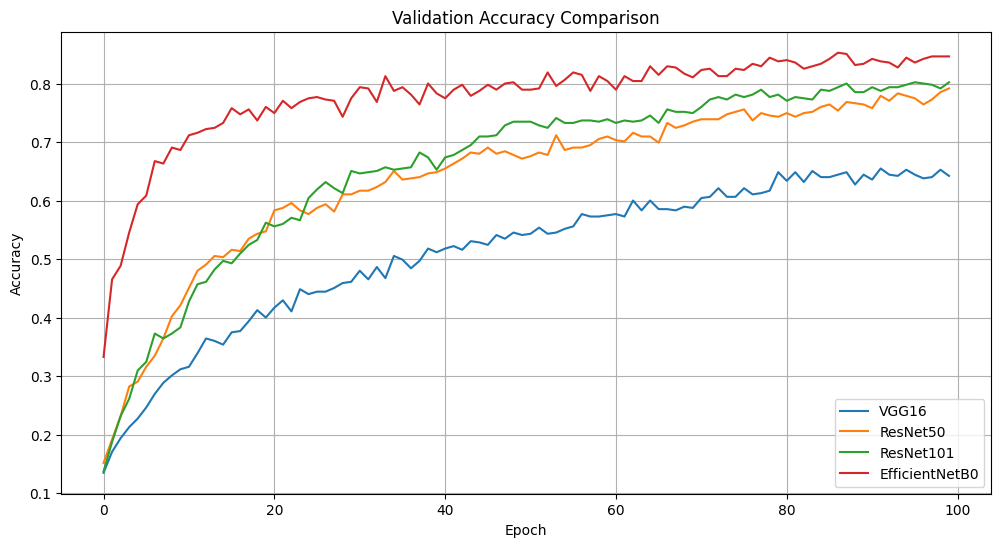

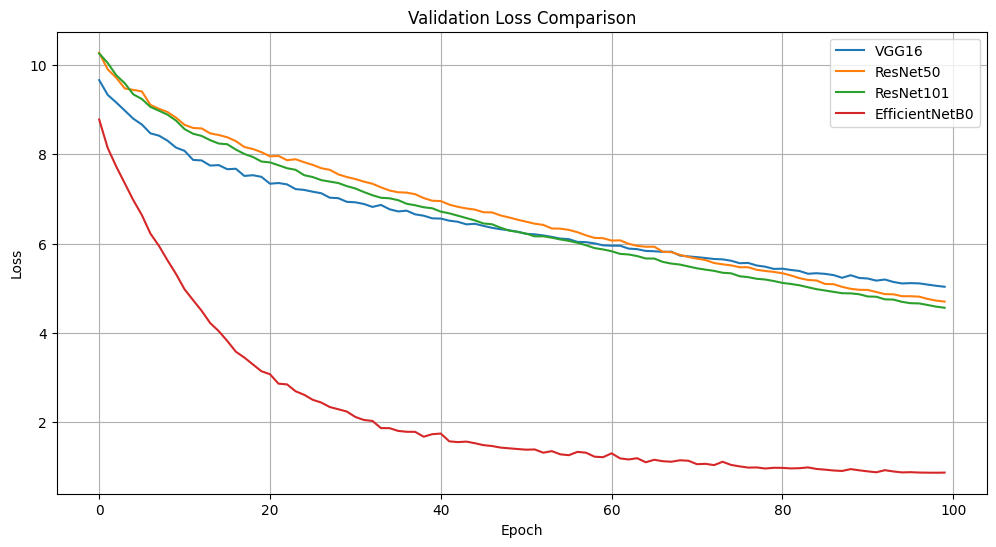

In [12]:
plt.figure(figsize=(12, 6))
for name, history in histories.items():
    plt.plot(history.history['val_accuracy'], label=f"{name}")
plt.title('Validation Accuracy Comparison')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 6))
for name, history in histories.items():
    plt.plot(history.history['val_loss'], label=f"{name}")
plt.title('Validation Loss Comparison')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

<b> Report training, validation, and test Precision, Recall, AUC, and F1 score for those models. Is there a model that clearly outperforms others? Remember that this is a multi-class classification problem.<b>

In [13]:
from sklearn.metrics import classification_report
import pandas as pd

def evaluate_model_on_test_set(model, model_name, preprocess_fn=None):
    print(f"\n--- Evaluation Report for {model_name} ---")
    X_test_proc = preprocess_fn(X_test.copy()) if preprocess_fn else X_test.copy()
    y_test_true = np.argmax(y_test, axis=1)

    y_test_probs = model.predict(X_test_proc, verbose=0)
    y_test_preds = np.argmax(y_test_probs, axis=1)

    class_names = [f"{i}-{label}" for i, label in enumerate(labels)]

    report = classification_report(y_test_true, y_test_preds, target_names=class_names, output_dict=True)
    report_df = pd.DataFrame(report).T.round(2)

    summary_rows = ['accuracy', 'macro avg', 'weighted avg']
    class_rows = [row for row in report_df.index if row not in summary_rows]
    report_df = report_df.loc[class_rows + summary_rows]

    print(report_df.to_string())


In [14]:
for name, model in models.items():
    preproc = {
        "VGG16": vgg_preproc,
        "ResNet50": resnet_preproc,
        "ResNet101": resnet_preproc,
        "EfficientNetB0": eff_preproc
    }[name]

    evaluate_model_on_test_set(model, name, preprocess_fn=preproc)



--- Evaluation Report for VGG16 ---
                         precision  recall  f1-score  support
0-1-Cardboard                 0.68    0.93      0.79     46.0
1-2-Food Organics             0.77    0.80      0.79     41.0
2-3-Glass                     0.50    0.90      0.64     42.0
3-4-Metal                     0.77    0.65      0.70     79.0
4-5-Miscellaneous Trash       0.61    0.50      0.55     50.0
5-6-Paper                     0.78    0.76      0.77     50.0
6-7-Plastic                   0.73    0.43      0.54     93.0
7-8-Textile Trash             0.77    0.84      0.81     32.0
8-9-Vegetation                0.81    0.91      0.86     43.0
accuracy                      0.70    0.70      0.70      0.7
macro avg                     0.71    0.75      0.72    476.0
weighted avg                  0.72    0.70      0.69    476.0

--- Evaluation Report for ResNet50 ---
                         precision  recall  f1-score  support
0-1-Cardboard                 0.72    0.91      0.81   

<b> EfficientNetB0 clearly outperforms VGG16, ResNet50, and ResNet101 across all major metrics — making it the best candidate for deployment or further fine-tuning.

 Why EfficientNetB0 Wins ? <b>
* Highest accuracy and F1-scores across the board.
* Consistent performance across almost all classes.
* Especially strong for challenging categories like:
  * Plastic: F1 = 0.80 (better than other models)
  * Glass and Food Organics: F1 ≈ 0.89–0.96

<b>Report Summary<b>

To evaluate model performance on the multi-class waste classification task, we compared four deep learning models: VGG16, ResNet50, ResNet101, and EfficientNetB0. We reported their precision, recall, and F1 scores on the test dataset. Among these, EfficientNetB0 clearly outperformed the rest, achieving the highest test accuracy of 85%, along with a macro F1-score of 0.86 and a weighted F1-score of 0.85. It consistently showed strong per-class performance, especially in challenging categories such as Plastic, Glass, and Food Organics. In contrast, VGG16 achieved the lowest accuracy (70%), while both ResNet variants lagged slightly behind EfficientNetB0 despite being deeper networks. These results indicate that EfficientNetB0 not only generalizes better but is also more computationally efficient. Hence, EfficientNetB0 is the recommended model for deployment in this multi-class classification problem.